# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:wisig",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "labels_target": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [3],
    "domains_target": [1, 2, 4],
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "n_shot": 3,
    "n_way": 130,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "wisig.node3-19.stratified_ds.2022A.pkl",
    "x_transforms_source": [],
    "x_transforms_target": [],
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source []
x_transforms_target []
Average magnitude, source: 0.058462173
Average power, source: 0.004701765


Average magnitude, target: 0.013294807
Average power, target: 0.00022007615


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 45], examples_per_second: 2010.0800, train_label_loss: 4.0864, 


epoch: 1, [batch: 5 / 45], examples_per_second: 3966.9735, train_label_loss: 3.3631, 


epoch: 1, [batch: 9 / 45], examples_per_second: 4072.1991, train_label_loss: 3.2937, 


epoch: 1, [batch: 14 / 45], examples_per_second: 4067.1936, train_label_loss: 2.8576, 


epoch: 1, [batch: 18 / 45], examples_per_second: 4069.1829, train_label_loss: 2.7095, 


epoch: 1, [batch: 23 / 45], examples_per_second: 3994.3224, train_label_loss: 2.3308, 


epoch: 1, [batch: 27 / 45], examples_per_second: 4067.1796, train_label_loss: 2.1281, 


epoch: 1, [batch: 31 / 45], examples_per_second: 4062.7188, train_label_loss: 1.9189, 


epoch: 1, [batch: 36 / 45], examples_per_second: 4100.2703, train_label_loss: 1.6576, 


epoch: 1, [batch: 40 / 45], examples_per_second: 4152.0189, train_label_loss: 1.3858, 


epoch: 1, source_val_acc_label: 0.8038, target_val_acc_label: 0.7474, source_val_label_loss: 1.4297, target_val_label_loss: 1.6363, 


New best


epoch: 2, [batch: 1 / 45], examples_per_second: 503.2183, train_label_loss: 1.3112, 


epoch: 2, [batch: 5 / 45], examples_per_second: 4043.2962, train_label_loss: 1.4311, 


epoch: 2, [batch: 9 / 45], examples_per_second: 4134.0377, train_label_loss: 1.1548, 


epoch: 2, [batch: 14 / 45], examples_per_second: 4138.7467, train_label_loss: 0.8517, 


epoch: 2, [batch: 18 / 45], examples_per_second: 4129.2024, train_label_loss: 0.9203, 


epoch: 2, [batch: 23 / 45], examples_per_second: 4043.0612, train_label_loss: 0.7721, 


epoch: 2, [batch: 27 / 45], examples_per_second: 4117.6041, train_label_loss: 0.8463, 


epoch: 2, [batch: 31 / 45], examples_per_second: 4130.4942, train_label_loss: 1.0376, 


epoch: 2, [batch: 36 / 45], examples_per_second: 4163.7549, train_label_loss: 0.6051, 


epoch: 2, [batch: 40 / 45], examples_per_second: 4225.7517, train_label_loss: 0.7574, 


epoch: 2, source_val_acc_label: 0.8667, target_val_acc_label: 0.7991, source_val_label_loss: 0.7792, target_val_label_loss: 1.0529, 


New best


epoch: 3, [batch: 1 / 45], examples_per_second: 497.1587, train_label_loss: 0.6354, 


epoch: 3, [batch: 5 / 45], examples_per_second: 4043.8225, train_label_loss: 0.6357, 


epoch: 3, [batch: 9 / 45], examples_per_second: 4143.4731, train_label_loss: 0.7363, 


epoch: 3, [batch: 14 / 45], examples_per_second: 4145.6960, train_label_loss: 0.5944, 


epoch: 3, [batch: 18 / 45], examples_per_second: 4142.2864, train_label_loss: 0.5454, 


epoch: 3, [batch: 23 / 45], examples_per_second: 4068.6394, train_label_loss: 0.6009, 


epoch: 3, [batch: 27 / 45], examples_per_second: 4145.2498, train_label_loss: 0.5494, 


epoch: 3, [batch: 31 / 45], examples_per_second: 4140.8284, train_label_loss: 0.4521, 


epoch: 3, [batch: 36 / 45], examples_per_second: 4175.1842, train_label_loss: 0.5580, 


epoch: 3, [batch: 40 / 45], examples_per_second: 4206.5467, train_label_loss: 0.7253, 


epoch: 3, source_val_acc_label: 0.8955, target_val_acc_label: 0.8284, source_val_label_loss: 0.6296, target_val_label_loss: 0.9317, 


New best


epoch: 4, [batch: 1 / 45], examples_per_second: 495.7866, train_label_loss: 0.4302, 


epoch: 4, [batch: 5 / 45], examples_per_second: 4038.6214, train_label_loss: 0.4969, 


epoch: 4, [batch: 9 / 45], examples_per_second: 4137.9939, train_label_loss: 0.4866, 


epoch: 4, [batch: 14 / 45], examples_per_second: 4137.8899, train_label_loss: 0.6716, 


epoch: 4, [batch: 18 / 45], examples_per_second: 4135.2871, train_label_loss: 0.4487, 


epoch: 4, [batch: 23 / 45], examples_per_second: 4055.7231, train_label_loss: 0.6718, 


epoch: 4, [batch: 27 / 45], examples_per_second: 4137.3314, train_label_loss: 0.4695, 


epoch: 4, [batch: 31 / 45], examples_per_second: 4131.3705, train_label_loss: 0.5001, 


epoch: 4, [batch: 36 / 45], examples_per_second: 4166.9228, train_label_loss: 0.4681, 


epoch: 4, [batch: 40 / 45], examples_per_second: 4226.4887, train_label_loss: 0.3879, 


epoch: 4, source_val_acc_label: 0.9231, target_val_acc_label: 0.8423, source_val_label_loss: 0.5405, target_val_label_loss: 0.8654, 


New best


epoch: 5, [batch: 1 / 45], examples_per_second: 497.5219, train_label_loss: 0.3744, 


epoch: 5, [batch: 5 / 45], examples_per_second: 4024.2530, train_label_loss: 0.3972, 


epoch: 5, [batch: 9 / 45], examples_per_second: 4121.5164, train_label_loss: 0.4946, 


epoch: 5, [batch: 14 / 45], examples_per_second: 4130.2433, train_label_loss: 0.2167, 


epoch: 5, [batch: 18 / 45], examples_per_second: 4125.5064, train_label_loss: 0.5997, 


epoch: 5, [batch: 23 / 45], examples_per_second: 4050.1354, train_label_loss: 0.5190, 


epoch: 5, [batch: 27 / 45], examples_per_second: 4129.5464, train_label_loss: 0.3573, 


epoch: 5, [batch: 31 / 45], examples_per_second: 4126.5274, train_label_loss: 0.5199, 


epoch: 5, [batch: 36 / 45], examples_per_second: 4172.7840, train_label_loss: 0.3925, 


epoch: 5, [batch: 40 / 45], examples_per_second: 4224.7776, train_label_loss: 0.3455, 


epoch: 5, source_val_acc_label: 0.9314, target_val_acc_label: 0.8526, source_val_label_loss: 0.4701, target_val_label_loss: 0.7937, 


New best


epoch: 6, [batch: 1 / 45], examples_per_second: 496.7782, train_label_loss: 0.5158, 


epoch: 6, [batch: 5 / 45], examples_per_second: 4031.8410, train_label_loss: 0.3545, 


epoch: 6, [batch: 9 / 45], examples_per_second: 4133.5300, train_label_loss: 0.3031, 


epoch: 6, [batch: 14 / 45], examples_per_second: 4131.7230, train_label_loss: 0.4334, 


epoch: 6, [batch: 18 / 45], examples_per_second: 4116.4089, train_label_loss: 0.3521, 


epoch: 6, [batch: 23 / 45], examples_per_second: 4058.5209, train_label_loss: 0.4995, 


epoch: 6, [batch: 27 / 45], examples_per_second: 4137.2874, train_label_loss: 0.4021, 


epoch: 6, [batch: 31 / 45], examples_per_second: 4137.5056, train_label_loss: 0.5809, 


epoch: 6, [batch: 36 / 45], examples_per_second: 4166.6872, train_label_loss: 0.3085, 


epoch: 6, [batch: 40 / 45], examples_per_second: 4226.6542, train_label_loss: 0.3271, 


epoch: 6, source_val_acc_label: 0.9372, target_val_acc_label: 0.8613, source_val_label_loss: 0.4418, target_val_label_loss: 0.7863, 


New best


epoch: 7, [batch: 1 / 45], examples_per_second: 497.5078, train_label_loss: 0.4324, 


epoch: 7, [batch: 5 / 45], examples_per_second: 4017.1552, train_label_loss: 0.3166, 


epoch: 7, [batch: 9 / 45], examples_per_second: 4119.4084, train_label_loss: 0.3503, 


epoch: 7, [batch: 14 / 45], examples_per_second: 4126.4174, train_label_loss: 0.1832, 


epoch: 7, [batch: 18 / 45], examples_per_second: 4120.5213, train_label_loss: 0.4162, 


epoch: 7, [batch: 23 / 45], examples_per_second: 4024.7137, train_label_loss: 0.4975, 


epoch: 7, [batch: 27 / 45], examples_per_second: 4125.4939, train_label_loss: 0.2891, 


epoch: 7, [batch: 31 / 45], examples_per_second: 4126.0184, train_label_loss: 0.2871, 


epoch: 7, [batch: 36 / 45], examples_per_second: 4166.3357, train_label_loss: 0.1443, 


epoch: 7, [batch: 40 / 45], examples_per_second: 4228.3782, train_label_loss: 0.4042, 


epoch: 7, source_val_acc_label: 0.9423, target_val_acc_label: 0.8652, source_val_label_loss: 0.4085, target_val_label_loss: 0.7576, 


New best


epoch: 8, [batch: 1 / 45], examples_per_second: 498.3773, train_label_loss: 0.2161, 


epoch: 8, [batch: 5 / 45], examples_per_second: 4040.1310, train_label_loss: 0.2323, 


epoch: 8, [batch: 9 / 45], examples_per_second: 4137.4648, train_label_loss: 0.3021, 


epoch: 8, [batch: 14 / 45], examples_per_second: 4143.8535, train_label_loss: 0.3405, 


epoch: 8, [batch: 18 / 45], examples_per_second: 4134.3198, train_label_loss: 0.3380, 


epoch: 8, [batch: 23 / 45], examples_per_second: 4061.8950, train_label_loss: 0.2890, 


epoch: 8, [batch: 27 / 45], examples_per_second: 4146.7756, train_label_loss: 0.4196, 


epoch: 8, [batch: 31 / 45], examples_per_second: 4135.9756, train_label_loss: 0.4071, 


epoch: 8, [batch: 36 / 45], examples_per_second: 4173.3065, train_label_loss: 0.2225, 


epoch: 8, [batch: 40 / 45], examples_per_second: 4224.9053, train_label_loss: 0.3356, 


epoch: 8, source_val_acc_label: 0.9500, target_val_acc_label: 0.8660, source_val_label_loss: 0.3974, target_val_label_loss: 0.7613, 


New best


epoch: 9, [batch: 1 / 45], examples_per_second: 494.3322, train_label_loss: 0.3125, 


epoch: 9, [batch: 5 / 45], examples_per_second: 4039.4142, train_label_loss: 0.3206, 


epoch: 9, [batch: 9 / 45], examples_per_second: 4138.0598, train_label_loss: 0.3263, 


epoch: 9, [batch: 14 / 45], examples_per_second: 4144.8288, train_label_loss: 0.2167, 


epoch: 9, [batch: 18 / 45], examples_per_second: 4136.8119, train_label_loss: 0.3037, 


epoch: 9, [batch: 23 / 45], examples_per_second: 4059.8844, train_label_loss: 0.3846, 


epoch: 9, [batch: 27 / 45], examples_per_second: 4131.5630, train_label_loss: 0.3162, 


epoch: 9, [batch: 31 / 45], examples_per_second: 4132.9300, train_label_loss: 0.2977, 


epoch: 9, [batch: 36 / 45], examples_per_second: 4170.7821, train_label_loss: 0.2164, 


epoch: 9, [batch: 40 / 45], examples_per_second: 4229.4770, train_label_loss: 0.2031, 


epoch: 9, source_val_acc_label: 0.9494, target_val_acc_label: 0.8673, source_val_label_loss: 0.3748, target_val_label_loss: 0.7418, 


New best


epoch: 10, [batch: 1 / 45], examples_per_second: 496.2571, train_label_loss: 0.2550, 


epoch: 10, [batch: 5 / 45], examples_per_second: 4017.1389, train_label_loss: 0.1670, 


epoch: 10, [batch: 9 / 45], examples_per_second: 4122.7427, train_label_loss: 0.2970, 


epoch: 10, [batch: 14 / 45], examples_per_second: 4118.6937, train_label_loss: 0.1712, 


epoch: 10, [batch: 18 / 45], examples_per_second: 4121.8607, train_label_loss: 0.3716, 


epoch: 10, [batch: 23 / 45], examples_per_second: 4041.5532, train_label_loss: 0.1795, 


epoch: 10, [batch: 27 / 45], examples_per_second: 4124.3830, train_label_loss: 0.2238, 


epoch: 10, [batch: 31 / 45], examples_per_second: 4117.9042, train_label_loss: 0.3031, 


epoch: 10, [batch: 36 / 45], examples_per_second: 4159.9226, train_label_loss: 0.3912, 


epoch: 10, [batch: 40 / 45], examples_per_second: 4223.7517, train_label_loss: 0.1093, 


epoch: 10, source_val_acc_label: 0.9500, target_val_acc_label: 0.8716, source_val_label_loss: 0.3469, target_val_label_loss: 0.6816, 


New best


epoch: 11, [batch: 1 / 45], examples_per_second: 493.8094, train_label_loss: 0.3562, 


epoch: 11, [batch: 5 / 45], examples_per_second: 4022.3812, train_label_loss: 0.1341, 


epoch: 11, [batch: 9 / 45], examples_per_second: 4120.3905, train_label_loss: 0.2995, 


epoch: 11, [batch: 14 / 45], examples_per_second: 4130.3271, train_label_loss: 0.3926, 


epoch: 11, [batch: 18 / 45], examples_per_second: 4108.6327, train_label_loss: 0.2836, 


epoch: 11, [batch: 23 / 45], examples_per_second: 4055.1319, train_label_loss: 0.3395, 


epoch: 11, [batch: 27 / 45], examples_per_second: 4131.8025, train_label_loss: 0.2802, 


epoch: 11, [batch: 31 / 45], examples_per_second: 4130.4504, train_label_loss: 0.1936, 


epoch: 11, [batch: 36 / 45], examples_per_second: 4168.6278, train_label_loss: 0.2456, 


epoch: 11, [batch: 40 / 45], examples_per_second: 4223.1481, train_label_loss: 0.1864, 


epoch: 11, source_val_acc_label: 0.9526, target_val_acc_label: 0.8686, source_val_label_loss: 0.3416, target_val_label_loss: 0.6914, 


epoch: 12, [batch: 1 / 45], examples_per_second: 510.1063, train_label_loss: 0.2261, 


epoch: 12, [batch: 5 / 45], examples_per_second: 4031.7694, train_label_loss: 0.3598, 


epoch: 12, [batch: 9 / 45], examples_per_second: 4119.6076, train_label_loss: 0.2528, 


epoch: 12, [batch: 14 / 45], examples_per_second: 4117.9882, train_label_loss: 0.2257, 


epoch: 12, [batch: 18 / 45], examples_per_second: 4120.8234, train_label_loss: 0.0811, 


epoch: 12, [batch: 23 / 45], examples_per_second: 4051.8063, train_label_loss: 0.2054, 


epoch: 12, [batch: 27 / 45], examples_per_second: 4129.1633, train_label_loss: 0.2579, 


epoch: 12, [batch: 31 / 45], examples_per_second: 4126.8053, train_label_loss: 0.1950, 


epoch: 12, [batch: 36 / 45], examples_per_second: 4161.4490, train_label_loss: 0.3618, 


epoch: 12, [batch: 40 / 45], examples_per_second: 4220.7225, train_label_loss: 0.2105, 


epoch: 12, source_val_acc_label: 0.9526, target_val_acc_label: 0.8791, source_val_label_loss: 0.3378, target_val_label_loss: 0.6765, 


New best


epoch: 13, [batch: 1 / 45], examples_per_second: 495.9251, train_label_loss: 0.2601, 


epoch: 13, [batch: 5 / 45], examples_per_second: 4033.3814, train_label_loss: 0.4436, 


epoch: 13, [batch: 9 / 45], examples_per_second: 4130.2533, train_label_loss: 0.2481, 


epoch: 13, [batch: 14 / 45], examples_per_second: 4137.1289, train_label_loss: 0.1739, 


epoch: 13, [batch: 18 / 45], examples_per_second: 4134.5972, train_label_loss: 0.1643, 


epoch: 13, [batch: 23 / 45], examples_per_second: 4054.2225, train_label_loss: 0.2880, 


epoch: 13, [batch: 27 / 45], examples_per_second: 4137.6642, train_label_loss: 0.2390, 


epoch: 13, [batch: 31 / 45], examples_per_second: 4129.5698, train_label_loss: 0.2416, 


epoch: 13, [batch: 36 / 45], examples_per_second: 4167.2489, train_label_loss: 0.2619, 


epoch: 13, [batch: 40 / 45], examples_per_second: 4223.9725, train_label_loss: 0.2830, 


epoch: 13, source_val_acc_label: 0.9519, target_val_acc_label: 0.8729, source_val_label_loss: 0.3331, target_val_label_loss: 0.6901, 


epoch: 14, [batch: 1 / 45], examples_per_second: 509.6876, train_label_loss: 0.1445, 


epoch: 14, [batch: 5 / 45], examples_per_second: 4030.2675, train_label_loss: 0.2406, 


epoch: 14, [batch: 9 / 45], examples_per_second: 4127.0334, train_label_loss: 0.1675, 


epoch: 14, [batch: 14 / 45], examples_per_second: 4129.7102, train_label_loss: 0.2344, 


epoch: 14, [batch: 18 / 45], examples_per_second: 4122.6461, train_label_loss: 0.1933, 


epoch: 14, [batch: 23 / 45], examples_per_second: 4053.3425, train_label_loss: 0.2593, 


epoch: 14, [batch: 27 / 45], examples_per_second: 4120.6085, train_label_loss: 0.3222, 


epoch: 14, [batch: 31 / 45], examples_per_second: 4129.0429, train_label_loss: 0.2423, 


epoch: 14, [batch: 36 / 45], examples_per_second: 4161.0743, train_label_loss: 0.1008, 


epoch: 14, [batch: 40 / 45], examples_per_second: 4233.2729, train_label_loss: 0.2526, 


epoch: 14, source_val_acc_label: 0.9551, target_val_acc_label: 0.8769, source_val_label_loss: 0.3349, target_val_label_loss: 0.6875, 


epoch: 15, [batch: 1 / 45], examples_per_second: 510.6338, train_label_loss: 0.2237, 


epoch: 15, [batch: 5 / 45], examples_per_second: 4029.0286, train_label_loss: 0.1624, 


epoch: 15, [batch: 9 / 45], examples_per_second: 4134.2790, train_label_loss: 0.2555, 


epoch: 15, [batch: 14 / 45], examples_per_second: 4137.4880, train_label_loss: 0.2344, 


epoch: 15, [batch: 18 / 45], examples_per_second: 4135.3137, train_label_loss: 0.2121, 


epoch: 15, [batch: 23 / 45], examples_per_second: 4055.0836, train_label_loss: 0.1899, 


epoch: 15, [batch: 27 / 45], examples_per_second: 4135.7591, train_label_loss: 0.2330, 


epoch: 15, [batch: 31 / 45], examples_per_second: 4132.1752, train_label_loss: 0.2135, 


epoch: 15, [batch: 36 / 45], examples_per_second: 4172.4966, train_label_loss: 0.2371, 


epoch: 15, [batch: 40 / 45], examples_per_second: 4223.6339, train_label_loss: 0.1591, 


epoch: 15, source_val_acc_label: 0.9577, target_val_acc_label: 0.8827, source_val_label_loss: 0.3489, target_val_label_loss: 0.6811, 


New best


epoch: 16, [batch: 1 / 45], examples_per_second: 496.1325, train_label_loss: 0.2406, 


epoch: 16, [batch: 5 / 45], examples_per_second: 4025.2319, train_label_loss: 0.2410, 


epoch: 16, [batch: 9 / 45], examples_per_second: 4125.3363, train_label_loss: 0.2915, 


epoch: 16, [batch: 14 / 45], examples_per_second: 4132.6349, train_label_loss: 0.3228, 


epoch: 16, [batch: 18 / 45], examples_per_second: 4117.1875, train_label_loss: 0.2150, 


epoch: 16, [batch: 23 / 45], examples_per_second: 4051.9906, train_label_loss: 0.2109, 


epoch: 16, [batch: 27 / 45], examples_per_second: 4126.7772, train_label_loss: 0.0947, 


epoch: 16, [batch: 31 / 45], examples_per_second: 4118.1561, train_label_loss: 0.1635, 


epoch: 16, [batch: 36 / 45], examples_per_second: 4159.9594, train_label_loss: 0.2044, 


epoch: 16, [batch: 40 / 45], examples_per_second: 4232.0309, train_label_loss: 0.1289, 


epoch: 16, source_val_acc_label: 0.9558, target_val_acc_label: 0.8814, source_val_label_loss: 0.3375, target_val_label_loss: 0.6627, 


epoch: 17, [batch: 1 / 45], examples_per_second: 503.6230, train_label_loss: 0.2171, 


epoch: 17, [batch: 5 / 45], examples_per_second: 3978.4313, train_label_loss: 0.1446, 


epoch: 17, [batch: 9 / 45], examples_per_second: 4010.4112, train_label_loss: 0.1110, 


epoch: 17, [batch: 14 / 45], examples_per_second: 4091.6637, train_label_loss: 0.1293, 


epoch: 17, [batch: 18 / 45], examples_per_second: 4110.5794, train_label_loss: 0.1857, 


epoch: 17, [batch: 23 / 45], examples_per_second: 4037.7463, train_label_loss: 0.1979, 


epoch: 17, [batch: 27 / 45], examples_per_second: 4125.8904, train_label_loss: 0.1015, 


epoch: 17, [batch: 31 / 45], examples_per_second: 4122.5931, train_label_loss: 0.0477, 


epoch: 17, [batch: 36 / 45], examples_per_second: 4168.2059, train_label_loss: 0.2234, 


epoch: 17, [batch: 40 / 45], examples_per_second: 4230.7207, train_label_loss: 0.2045, 


epoch: 17, source_val_acc_label: 0.9571, target_val_acc_label: 0.8859, source_val_label_loss: 0.3222, target_val_label_loss: 0.6665, 


New best


epoch: 18, [batch: 1 / 45], examples_per_second: 501.1225, train_label_loss: 0.2075, 


epoch: 18, [batch: 5 / 45], examples_per_second: 4028.4407, train_label_loss: 0.3126, 


epoch: 18, [batch: 9 / 45], examples_per_second: 4117.1036, train_label_loss: 0.1614, 


epoch: 18, [batch: 14 / 45], examples_per_second: 4113.4699, train_label_loss: 0.2594, 


epoch: 18, [batch: 18 / 45], examples_per_second: 4138.7964, train_label_loss: 0.2020, 


epoch: 18, [batch: 23 / 45], examples_per_second: 4058.0678, train_label_loss: 0.1493, 


epoch: 18, [batch: 27 / 45], examples_per_second: 4136.6910, train_label_loss: 0.0667, 


epoch: 18, [batch: 31 / 45], examples_per_second: 4135.6007, train_label_loss: 0.1157, 


epoch: 18, [batch: 36 / 45], examples_per_second: 4171.6998, train_label_loss: 0.1463, 


epoch: 18, [batch: 40 / 45], examples_per_second: 4224.2883, train_label_loss: 0.0957, 


epoch: 18, source_val_acc_label: 0.9596, target_val_acc_label: 0.8870, source_val_label_loss: 0.2976, target_val_label_loss: 0.6218, 


New best


epoch: 19, [batch: 1 / 45], examples_per_second: 493.8282, train_label_loss: 0.1980, 


epoch: 19, [batch: 5 / 45], examples_per_second: 4038.3656, train_label_loss: 0.1462, 


epoch: 19, [batch: 9 / 45], examples_per_second: 4133.5488, train_label_loss: 0.0942, 


epoch: 19, [batch: 14 / 45], examples_per_second: 4132.6487, train_label_loss: 0.1216, 


epoch: 19, [batch: 18 / 45], examples_per_second: 4131.2938, train_label_loss: 0.1637, 


epoch: 19, [batch: 23 / 45], examples_per_second: 4058.2937, train_label_loss: 0.1549, 


epoch: 19, [batch: 27 / 45], examples_per_second: 4132.0280, train_label_loss: 0.1554, 


epoch: 19, [batch: 31 / 45], examples_per_second: 4132.5839, train_label_loss: 0.1356, 


epoch: 19, [batch: 36 / 45], examples_per_second: 4168.9249, train_label_loss: 0.2185, 


epoch: 19, [batch: 40 / 45], examples_per_second: 4227.3472, train_label_loss: 0.1474, 


epoch: 19, source_val_acc_label: 0.9558, target_val_acc_label: 0.8870, source_val_label_loss: 0.3300, target_val_label_loss: 0.6534, 


epoch: 20, [batch: 1 / 45], examples_per_second: 504.2206, train_label_loss: 0.1194, 


epoch: 20, [batch: 5 / 45], examples_per_second: 4032.0601, train_label_loss: 0.1408, 


epoch: 20, [batch: 9 / 45], examples_per_second: 4134.8026, train_label_loss: 0.1127, 


epoch: 20, [batch: 14 / 45], examples_per_second: 4139.5649, train_label_loss: 0.2367, 


epoch: 20, [batch: 18 / 45], examples_per_second: 4136.6565, train_label_loss: 0.1210, 


epoch: 20, [batch: 23 / 45], examples_per_second: 4057.0931, train_label_loss: 0.1367, 


epoch: 20, [batch: 27 / 45], examples_per_second: 4128.7975, train_label_loss: 0.2292, 


epoch: 20, [batch: 31 / 45], examples_per_second: 4143.3677, train_label_loss: 0.1702, 


epoch: 20, [batch: 36 / 45], examples_per_second: 4170.4848, train_label_loss: 0.0803, 


epoch: 20, [batch: 40 / 45], examples_per_second: 4230.9029, train_label_loss: 0.0841, 


epoch: 20, source_val_acc_label: 0.9583, target_val_acc_label: 0.8906, source_val_label_loss: 0.3035, target_val_label_loss: 0.6248, 


New best


epoch: 21, [batch: 1 / 45], examples_per_second: 491.6508, train_label_loss: 0.1703, 


epoch: 21, [batch: 5 / 45], examples_per_second: 4023.8788, train_label_loss: 0.2344, 


epoch: 21, [batch: 9 / 45], examples_per_second: 4132.5447, train_label_loss: 0.2702, 


epoch: 21, [batch: 14 / 45], examples_per_second: 4128.6021, train_label_loss: 0.1223, 


epoch: 21, [batch: 18 / 45], examples_per_second: 4130.7946, train_label_loss: 0.2124, 


epoch: 21, [batch: 23 / 45], examples_per_second: 4053.6956, train_label_loss: 0.1216, 


epoch: 21, [batch: 27 / 45], examples_per_second: 4129.9827, train_label_loss: 0.1719, 


epoch: 21, [batch: 31 / 45], examples_per_second: 4130.7618, train_label_loss: 0.1086, 


epoch: 21, [batch: 36 / 45], examples_per_second: 4165.9244, train_label_loss: 0.1526, 


epoch: 21, [batch: 40 / 45], examples_per_second: 4228.1799, train_label_loss: 0.1393, 


epoch: 21, source_val_acc_label: 0.9564, target_val_acc_label: 0.8897, source_val_label_loss: 0.3100, target_val_label_loss: 0.6199, 


epoch: 22, [batch: 1 / 45], examples_per_second: 509.9663, train_label_loss: 0.1880, 


epoch: 22, [batch: 5 / 45], examples_per_second: 4031.0615, train_label_loss: 0.1395, 


epoch: 22, [batch: 9 / 45], examples_per_second: 4137.8431, train_label_loss: 0.1777, 


epoch: 22, [batch: 14 / 45], examples_per_second: 4141.6276, train_label_loss: 0.2353, 


epoch: 22, [batch: 18 / 45], examples_per_second: 4133.5394, train_label_loss: 0.1620, 


epoch: 22, [batch: 23 / 45], examples_per_second: 4059.7429, train_label_loss: 0.1781, 


epoch: 22, [batch: 27 / 45], examples_per_second: 4139.0791, train_label_loss: 0.2349, 


epoch: 22, [batch: 31 / 45], examples_per_second: 4128.2129, train_label_loss: 0.1228, 


epoch: 22, [batch: 36 / 45], examples_per_second: 4177.0854, train_label_loss: 0.1243, 


epoch: 22, [batch: 40 / 45], examples_per_second: 4229.9806, train_label_loss: 0.1680, 


epoch: 22, source_val_acc_label: 0.9571, target_val_acc_label: 0.8915, source_val_label_loss: 0.2951, target_val_label_loss: 0.6083, 


New best


epoch: 23, [batch: 1 / 45], examples_per_second: 494.8898, train_label_loss: 0.2168, 


epoch: 23, [batch: 5 / 45], examples_per_second: 4018.3690, train_label_loss: 0.1092, 


epoch: 23, [batch: 9 / 45], examples_per_second: 4126.0762, train_label_loss: 0.2438, 


epoch: 23, [batch: 14 / 45], examples_per_second: 4116.0372, train_label_loss: 0.2480, 


epoch: 23, [batch: 18 / 45], examples_per_second: 4122.6398, train_label_loss: 0.3323, 


epoch: 23, [batch: 23 / 45], examples_per_second: 4051.1453, train_label_loss: 0.1899, 


epoch: 23, [batch: 27 / 45], examples_per_second: 4131.5896, train_label_loss: 0.1184, 


epoch: 23, [batch: 31 / 45], examples_per_second: 4134.9798, train_label_loss: 0.1475, 


epoch: 23, [batch: 36 / 45], examples_per_second: 4172.0765, train_label_loss: 0.2229, 


epoch: 23, [batch: 40 / 45], examples_per_second: 4228.7931, train_label_loss: 0.1767, 


epoch: 23, source_val_acc_label: 0.9558, target_val_acc_label: 0.8900, source_val_label_loss: 0.3000, target_val_label_loss: 0.6300, 


epoch: 24, [batch: 1 / 45], examples_per_second: 511.6533, train_label_loss: 0.1687, 


epoch: 24, [batch: 5 / 45], examples_per_second: 4028.5359, train_label_loss: 0.0670, 


epoch: 24, [batch: 9 / 45], examples_per_second: 4132.4335, train_label_loss: 0.1387, 


epoch: 24, [batch: 14 / 45], examples_per_second: 4136.8916, train_label_loss: 0.2502, 


epoch: 24, [batch: 18 / 45], examples_per_second: 4126.8506, train_label_loss: 0.0786, 


epoch: 24, [batch: 23 / 45], examples_per_second: 4055.9439, train_label_loss: 0.1104, 


epoch: 24, [batch: 27 / 45], examples_per_second: 4131.8871, train_label_loss: 0.2259, 


epoch: 24, [batch: 31 / 45], examples_per_second: 4123.1979, train_label_loss: 0.1238, 


epoch: 24, [batch: 36 / 45], examples_per_second: 4169.7678, train_label_loss: 0.1174, 


epoch: 24, [batch: 40 / 45], examples_per_second: 4225.9122, train_label_loss: 0.1508, 


epoch: 24, source_val_acc_label: 0.9564, target_val_acc_label: 0.8793, source_val_label_loss: 0.3124, target_val_label_loss: 0.6606, 


epoch: 25, [batch: 1 / 45], examples_per_second: 510.6387, train_label_loss: 0.2248, 


epoch: 25, [batch: 5 / 45], examples_per_second: 4035.8951, train_label_loss: 0.1658, 


epoch: 25, [batch: 9 / 45], examples_per_second: 4130.1172, train_label_loss: 0.2489, 


epoch: 25, [batch: 14 / 45], examples_per_second: 4135.6917, train_label_loss: 0.0931, 


epoch: 25, [batch: 18 / 45], examples_per_second: 4139.0744, train_label_loss: 0.1173, 


epoch: 25, [batch: 23 / 45], examples_per_second: 4058.4025, train_label_loss: 0.2656, 


epoch: 25, [batch: 27 / 45], examples_per_second: 4132.3020, train_label_loss: 0.1455, 


epoch: 25, [batch: 31 / 45], examples_per_second: 4136.4996, train_label_loss: 0.1876, 


epoch: 25, [batch: 36 / 45], examples_per_second: 4164.2802, train_label_loss: 0.0783, 


epoch: 25, [batch: 40 / 45], examples_per_second: 4226.1922, train_label_loss: 0.0373, 


epoch: 25, source_val_acc_label: 0.9583, target_val_acc_label: 0.8908, source_val_label_loss: 0.3063, target_val_label_loss: 0.6278, 


epoch: 26, [batch: 1 / 45], examples_per_second: 512.9608, train_label_loss: 0.0777, 


epoch: 26, [batch: 5 / 45], examples_per_second: 4002.1236, train_label_loss: 0.2407, 


epoch: 26, [batch: 9 / 45], examples_per_second: 4120.8390, train_label_loss: 0.1318, 


epoch: 26, [batch: 14 / 45], examples_per_second: 4123.4629, train_label_loss: 0.0847, 


epoch: 26, [batch: 18 / 45], examples_per_second: 4124.9602, train_label_loss: 0.0731, 


epoch: 26, [batch: 23 / 45], examples_per_second: 4048.8374, train_label_loss: 0.1645, 


epoch: 26, [batch: 27 / 45], examples_per_second: 4129.9373, train_label_loss: 0.1228, 


epoch: 26, [batch: 31 / 45], examples_per_second: 4129.0022, train_label_loss: 0.1963, 


epoch: 26, [batch: 36 / 45], examples_per_second: 4168.7935, train_label_loss: 0.1714, 


epoch: 26, [batch: 40 / 45], examples_per_second: 4231.1869, train_label_loss: 0.1451, 


epoch: 26, source_val_acc_label: 0.9590, target_val_acc_label: 0.8966, source_val_label_loss: 0.2941, target_val_label_loss: 0.5938, 


New best


epoch: 27, [batch: 1 / 45], examples_per_second: 493.1255, train_label_loss: 0.1483, 


epoch: 27, [batch: 5 / 45], examples_per_second: 4026.4744, train_label_loss: 0.1830, 


epoch: 27, [batch: 9 / 45], examples_per_second: 4129.9452, train_label_loss: 0.2115, 


epoch: 27, [batch: 14 / 45], examples_per_second: 4131.7531, train_label_loss: 0.0813, 


epoch: 27, [batch: 18 / 45], examples_per_second: 4117.6772, train_label_loss: 0.0606, 


epoch: 27, [batch: 23 / 45], examples_per_second: 4050.7648, train_label_loss: 0.0793, 


epoch: 27, [batch: 27 / 45], examples_per_second: 4120.9339, train_label_loss: 0.1310, 


epoch: 27, [batch: 31 / 45], examples_per_second: 4125.9388, train_label_loss: 0.1932, 


epoch: 27, [batch: 36 / 45], examples_per_second: 4168.9899, train_label_loss: 0.1995, 


epoch: 27, [batch: 40 / 45], examples_per_second: 4227.5701, train_label_loss: 0.1639, 


epoch: 27, source_val_acc_label: 0.9590, target_val_acc_label: 0.8940, source_val_label_loss: 0.2834, target_val_label_loss: 0.5924, 


epoch: 28, [batch: 1 / 45], examples_per_second: 509.8936, train_label_loss: 0.1743, 


epoch: 28, [batch: 5 / 45], examples_per_second: 4029.6167, train_label_loss: 0.2258, 


epoch: 28, [batch: 9 / 45], examples_per_second: 4138.4493, train_label_loss: 0.0634, 


epoch: 28, [batch: 14 / 45], examples_per_second: 4143.9090, train_label_loss: 0.1831, 


epoch: 28, [batch: 18 / 45], examples_per_second: 4137.1556, train_label_loss: 0.1501, 


epoch: 28, [batch: 23 / 45], examples_per_second: 4054.0658, train_label_loss: 0.1514, 


epoch: 28, [batch: 27 / 45], examples_per_second: 4128.9225, train_label_loss: 0.1997, 


epoch: 28, [batch: 31 / 45], examples_per_second: 4138.3550, train_label_loss: 0.0945, 


epoch: 28, [batch: 36 / 45], examples_per_second: 4170.4937, train_label_loss: 0.1323, 


epoch: 28, [batch: 40 / 45], examples_per_second: 4224.6713, train_label_loss: 0.3002, 


epoch: 28, source_val_acc_label: 0.9590, target_val_acc_label: 0.8891, source_val_label_loss: 0.3182, target_val_label_loss: 0.6412, 


epoch: 29, [batch: 1 / 45], examples_per_second: 506.0714, train_label_loss: 0.2145, 


epoch: 29, [batch: 5 / 45], examples_per_second: 4027.4201, train_label_loss: 0.1458, 


epoch: 29, [batch: 9 / 45], examples_per_second: 4115.5979, train_label_loss: 0.1803, 


epoch: 29, [batch: 14 / 45], examples_per_second: 4131.9923, train_label_loss: 0.1422, 


epoch: 29, [batch: 18 / 45], examples_per_second: 4128.7990, train_label_loss: 0.1725, 


epoch: 29, [batch: 23 / 45], examples_per_second: 4046.7423, train_label_loss: 0.2209, 


epoch: 29, [batch: 27 / 45], examples_per_second: 4133.5754, train_label_loss: 0.1579, 


epoch: 29, [batch: 31 / 45], examples_per_second: 4128.6568, train_label_loss: 0.1441, 


epoch: 29, [batch: 36 / 45], examples_per_second: 4167.5407, train_label_loss: 0.0982, 


epoch: 29, [batch: 40 / 45], examples_per_second: 4227.8389, train_label_loss: 0.1330, 


epoch: 29, source_val_acc_label: 0.9583, target_val_acc_label: 0.8912, source_val_label_loss: 0.2982, target_val_label_loss: 0.6076, 


epoch: 30, [batch: 1 / 45], examples_per_second: 510.6574, train_label_loss: 0.0729, 


epoch: 30, [batch: 5 / 45], examples_per_second: 4039.2302, train_label_loss: 0.2568, 


epoch: 30, [batch: 9 / 45], examples_per_second: 4132.0703, train_label_loss: 0.0811, 


epoch: 30, [batch: 14 / 45], examples_per_second: 4135.4784, train_label_loss: 0.1219, 


epoch: 30, [batch: 18 / 45], examples_per_second: 4128.4458, train_label_loss: 0.1186, 


epoch: 30, [batch: 23 / 45], examples_per_second: 4060.2762, train_label_loss: 0.0901, 


epoch: 30, [batch: 27 / 45], examples_per_second: 4139.6165, train_label_loss: 0.1728, 


epoch: 30, [batch: 31 / 45], examples_per_second: 4138.2985, train_label_loss: 0.0257, 


epoch: 30, [batch: 36 / 45], examples_per_second: 4173.5390, train_label_loss: 0.2302, 


epoch: 30, [batch: 40 / 45], examples_per_second: 4224.4847, train_label_loss: 0.0725, 


epoch: 30, source_val_acc_label: 0.9577, target_val_acc_label: 0.8962, source_val_label_loss: 0.2755, target_val_label_loss: 0.5802, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

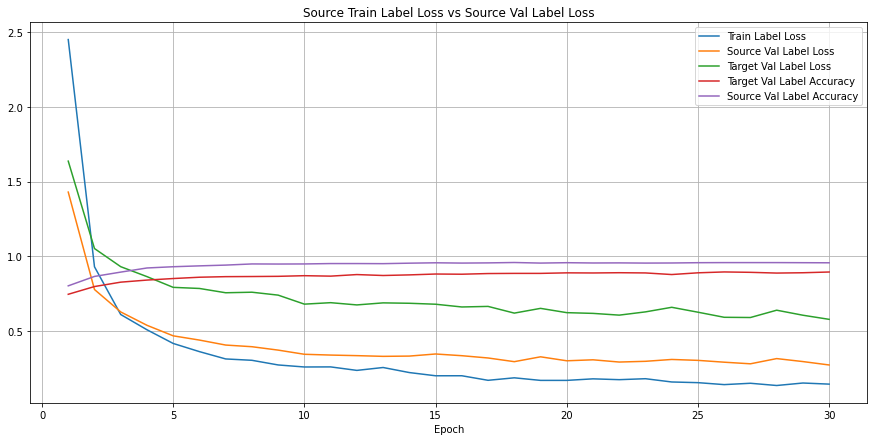

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

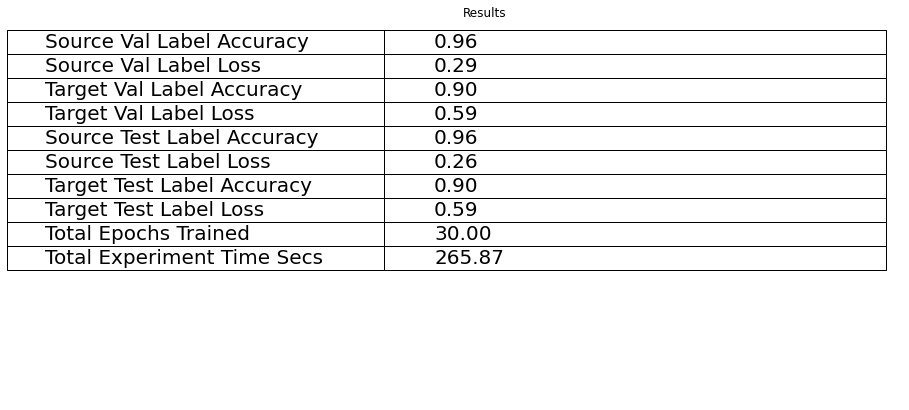

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

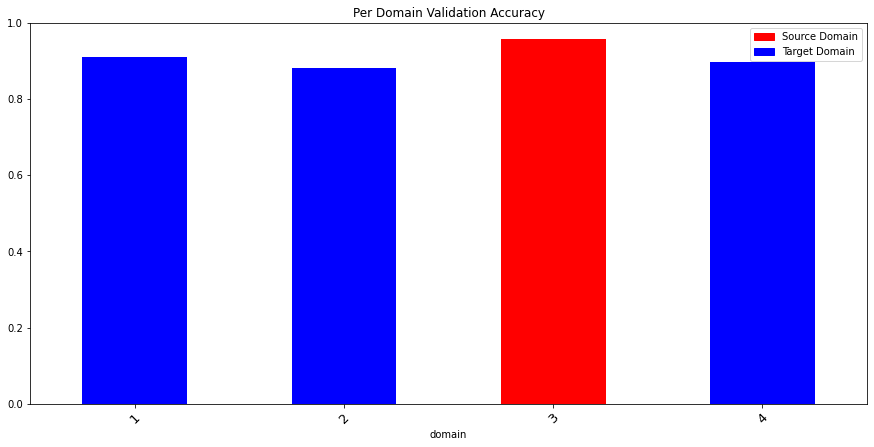

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9564102564102565 Target Test Label Accuracy: 0.8985042735042735
Source Val Label Accuracy: 0.958974358974359 Target Val Label Accuracy: 0.8965811965811966


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:wisig", "parameters": {"experiment_name": "tuned_1v2:wisig", "device": "cuda", "lr": 0.0001, "labels_source": ["1-10", "1-12", "1-14", "1-16", "1-18", "1-19", "1-8", "10-11", "10-17", "10-4", "10-7", "11-1", "11-10", "11-19", "11-20", "11-4", "11-7", "12-19", "12-20", "12-7", "13-14", "13-18", "13-19", "13-20", "13-3", "13-7", "14-10", "14-11", "14-12", "14-13", "14-14", "14-19", "14-20", "14-7", "14-8", "14-9", "15-1", "15-19", "15-6", "16-1", "16-16", "16-19", "16-20", "17-10", "17-11", "18-1", "18-10", "18-11", "18-12", "18-13", "18-14", "18-15", "18-16", "18-17", "18-19", "18-2", "18-20", "18-4", "18-5", "18-7", "18-8", "18-9", "19-1", "19-10", "19-11", "19-12", "19-13", "19-14", "19-15", "19-19", "19-2", "19-20", "19-3", "19-4", "19-6", "19-7", "19-8", "19-9", "2-1", "2-13", "2-15", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", "20-1", "20-12", "20-14", "20-15", "20-16", "20-18", "20-19", "20-20", "20-3", "20-4", "20-5", "20-7", "20-8", "3-1", "3-13", "